# keras tutorialと同じ工程+ロジスティック回帰してみよう

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
import glob

C:\Users\quark\Anaconda3\envs\myenv\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\quark\Anaconda3\envs\myenv\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\quark\Anaconda3\envs\myenv\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
plt.style.use('seaborn-darkgrid')
plt.rcParams['font.family'] = 'Yu Gothic'
plt.rcParams['font.size'] = 17

In [3]:
#np.loadして、trainとtestを分けよう
photo_data = np.load('learning_photo_data.npz')['arr_0']
label_data = np.load('learning_photo_data.npz')['arr_1']

In [4]:
train_photo = photo_data[:340000]
train_label = label_data[:340000]
test_photo = photo_data[340000:]
test_label = label_data[340000:] #ほんとは正解無いけどね

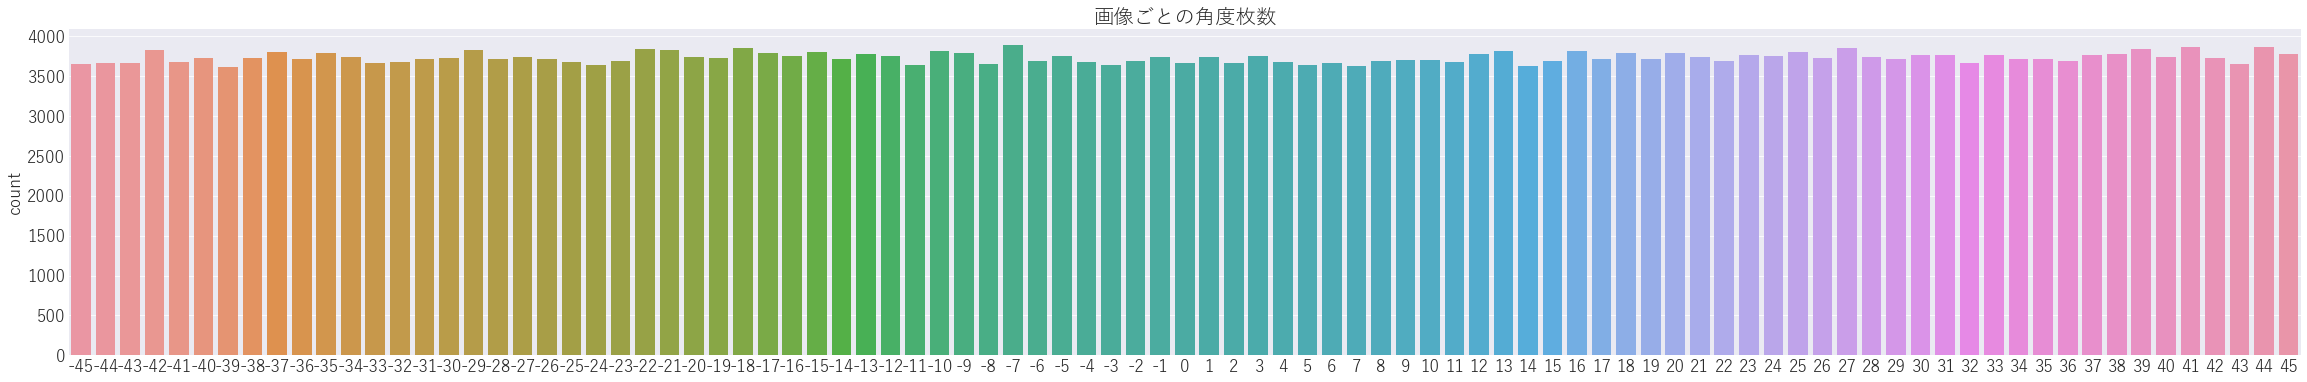

In [5]:
plt.figure(figsize=(40, 6))
sns.countplot(train_label)
plt.title('画像ごとの角度枚数')
plt.show()

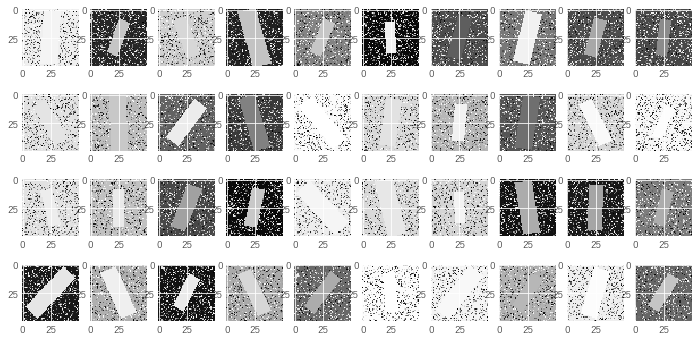

In [6]:
#レシートの画像表示
%matplotlib inline
plt.figure(figsize=(12, 6))
x, y = 10, 4
for i in range(40):
    plt.subplot(y, x, i + 1)
    plt.imshow(train_photo[i].reshape(50, 50), interpolation='nearest', cmap='Greys_r')
plt.show()

In [7]:
#画像の数値データ範囲を0~1へ
train_photo_1 = train_photo / 255
test_photo_1 = test_photo / 255

In [11]:
#実行時時間かかります。メモリ食います。
#ロジスティック回帰をしてみているぞ
from sklearn.linear_model import LogisticRegression

#これ用に1回分割しよっか
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_photo_1, train_label, test_size = 0.25)
logistic = LogisticRegression(verbose=1)
logistic.fit(x_train.reshape(255000, 2500), y_train)

#警告として収束してないぞと出るね
y_pred = logistic.predict(x_valid.reshape(85000, 2500))
#精度38%
np.count_nonzero(y_pred == y_valid) / len(y_valid)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\quark\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.1min finished


0.3806705882352941

In [8]:
#MNISTが分類数10種に対して91種類の正解データがあるため、データ容量を増やす必要がある
len(np.unique(train_label))

91

## とりま深層学習やってみますか
以降実行待ちよ

In [9]:
#とりあえずロジスティックの結果はどうとして、深層学習やってみるか
#カラーの次元を追加する必要があるので、4次元にしないといけない
X_train = train_photo_1.reshape(train_photo_1.shape[0], 50, 50, 1)
X_test = test_photo_1.reshape(test_photo_1.shape[0], 50, 50, 1)

In [12]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
num_classes = 91
epochs = 20
input_shape = (50, 50, 1)
batch_size = 64

In [13]:
#4次元にしてるから、結局train_test_splitまたやるんだな

#目的変数をカテゴリの数xデータ数でフラグを立てる2次元データにする
y_train = keras.utils.to_categorical(train_label, num_classes)
#ちなみにこの変換すると、0→45→-45→-1のながれになる

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [14]:
X_train.shape

(306000, 50, 50, 1)

In [15]:
#深層学習定義
#一旦簡単にやってみようか Conv2D,Flatten,Dense,Denseくらいで
model = Sequential()
#Conv2D
#kernel_initializerはweight+初期化
#種類は相当ある he_normal Heの正規分布による初期化を返す 平均0 標準偏差
# He = Newral Networkに技術を取り入れた人の名前
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', kernel_initializer='he_normal', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=(2, 2), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(Conv2D(64, kernel_size=(2, 2), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=(2, 2), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(Conv2D(128, kernel_size=(2, 2), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, kernel_size=(2, 2), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, input_shape=input_shape))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(learning_rate=0.0001),
             metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                           patience=3,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.0001)
datagen = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=0,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 49, 49, 32)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        4128      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        8256      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        16448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0

In [16]:
#ここでDataImageGeneratorのバッチに当てる
datagen.fit(X_train)

h = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                       epochs = epochs, validation_data = (X_valid, Y_valid),
                       verbose = 1, steps_per_epoch = X_train.shape[0] // batch_size,
                       callbacks=[learning_rate_reduction])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
4781/4781 [==============================] - 814s 170ms/step - loss: 3.2763 - accuracy: 0.0821 - val_loss: 2.3577 - val_accuracy: 0.2167 - lr: 1.0000e-04
Epoch 2/20
4781/4781 [==============================] - 829s 173ms/step - loss: 2.3842 - accuracy: 0.1641 - val_loss: 1.8468 - val_accuracy: 0.3116 - lr: 1.0000e-04
Epoch 3/20
4781/4781 [==============================] - 824s 172ms/step - loss: 2.0815 - accuracy: 0.2137 - val_loss: 1.6347 - val_accuracy: 0.3670 - lr: 1.0000e-04
Epoch 4/20
4781/4781 [==============================] - 812s 170ms/step - loss: 1.9307 - accuracy: 0.2449 - val_loss: 1.5442 - val_accuracy: 0.3756 - lr: 1.0000e-04
Epoch 5/20
4781/4781 [==============================] - 778s 163ms/step - loss: 1.8340 - accuracy: 0.2681 - val_loss: 1.4422 - val_accuracy: 0.4071 - lr: 1.0000e-04
Epoch 6/20
4781/4781 [==============================] - 778s 163ms/step - loss: 1.7678 - accuracy: 

In [17]:
#現状結果
final_loss, final_acc = model.evaluate(X_valid, Y_valid, verbose=0)
print('Final loss : {0:.6f}, Final accuracy: {1:.6f}'.format(final_loss, final_acc))

Final loss : 1.282574, Final accuracy: 0.437500


In [18]:
#predict
Y_pred = model.predict(X_valid)
#91の分類に対してsoftmaxで全部足した値の結果が入ってる
print(Y_pred.shape)

#softmaxで最大の値の配列値をargmaxで取得する
Y_pred_classes = np.argmax(Y_pred, axis=1)

#実際の値も同じことをする
Y_true = np.argmax(Y_valid, axis=1)

#Y_predのargmax
print(Y_pred_classes)

#Y_trueのargmax
print(Y_true)

#混同行列を作成
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

(34000, 91)
[29 26 59 ... 36 70 65]
[28 28 59 ... 37 68 63]


In [19]:
confusion_mtx

array([[345,   2,   0, ...,   0,   0,   1],
       [136, 151, 113, ...,   0,   0,   2],
       [  0,  72, 212, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 193,  86,  30],
       [  1,   0,   0, ...,  78, 113, 165],
       [116,   1,   1, ...,   0,  17, 237]], dtype=int64)

In [20]:
#混同行列をプロットしてくれるやつ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(25, 25))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize: #標準化
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, cm[i, j],
                horizontalalignment='center',
                color='white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## 予測精度として、ピッタリは43%程ですが、大体誤差±2度程での予測結果

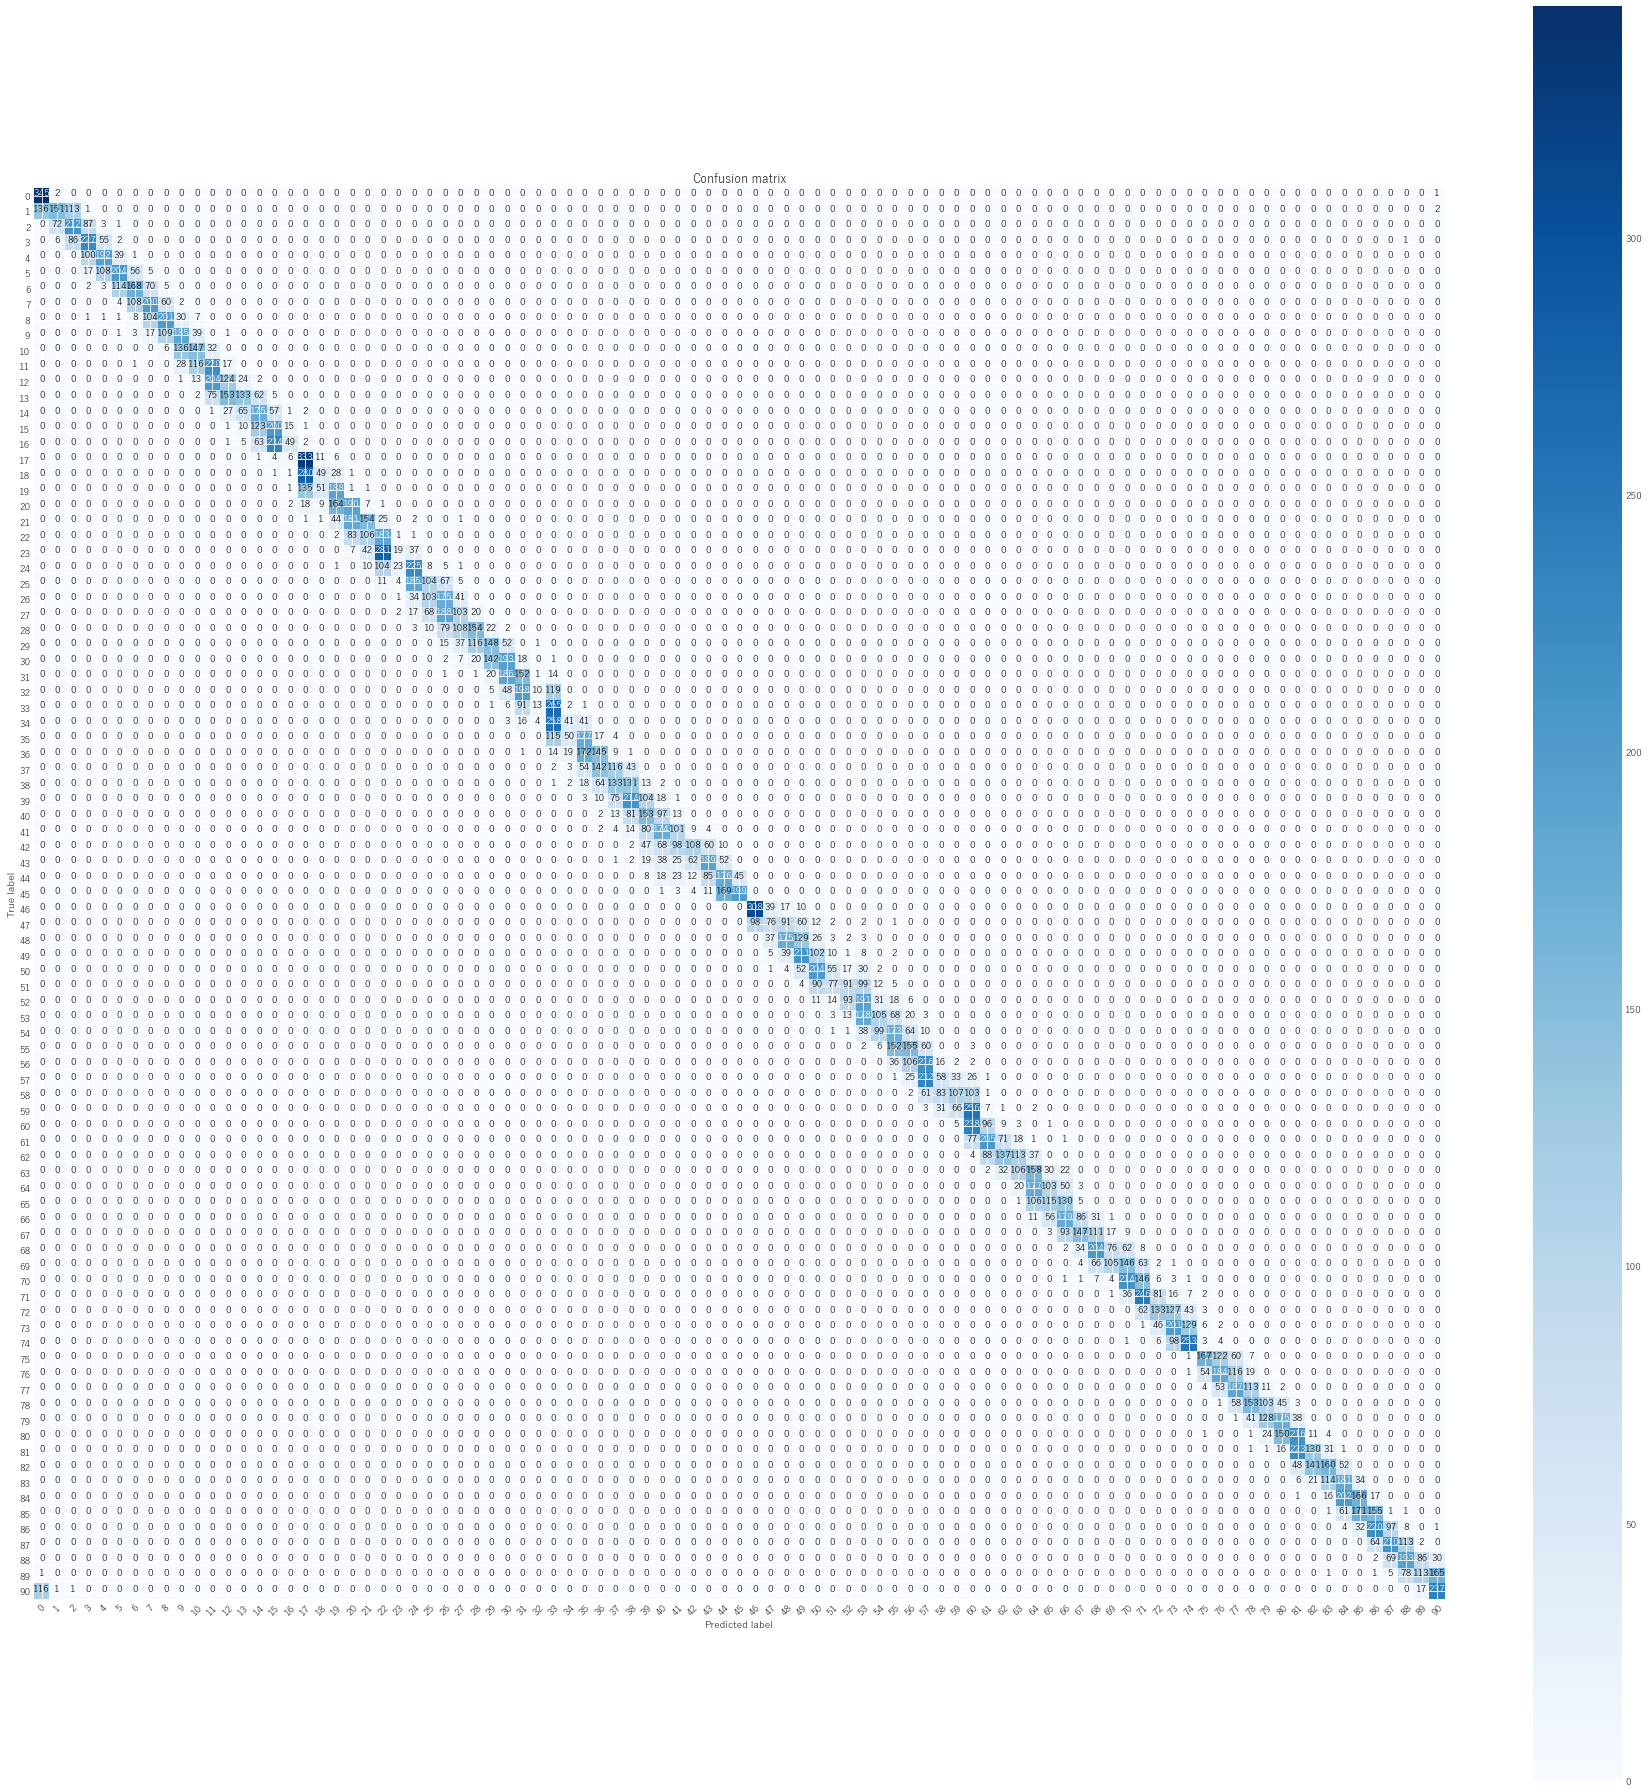

In [21]:
#0 = 0 
#45 = 45 
#46 = -45
#91 = -1
#-45と45度は完璧な予測結果
plot_confusion_matrix(confusion_mtx, classes = range(91))

In [22]:
#historyで経緯が見られる
print(h.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


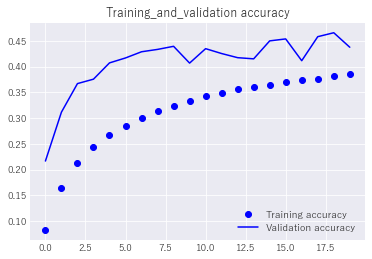

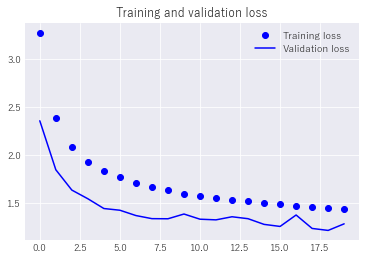

In [23]:
accuracy = h.history['accuracy']
val_accuracy = h.history['val_accuracy']
loss = h.history['loss']
val_loss = h.history['val_loss']
epochs = range(len(accuracy)) #学習回数

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training_and_validation accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

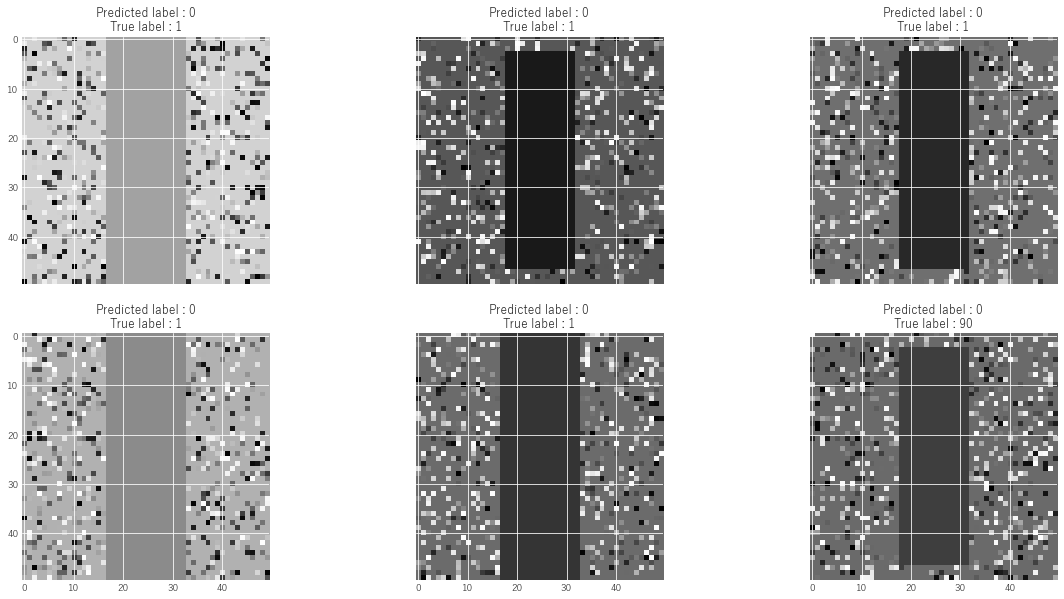

In [24]:
#error = 予測ラベルと真のラベルの違い
errors = (Y_pred_classes - Y_true != 0)

#それぞれ割り当て
Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_valid[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    #6つの画像とその予測ラベルと実際のラベルと表示する
    n = 0
    nrows = 2
    ncols = 3
    #plt.figure(figsize=(20, 10))
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(20, 10))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row, col].imshow((img_errors[error]).reshape((50,50)))
            ax[row, col].set_title('Predicted label : {}\nTrue label : {}'.format(pred_errors[error], obs_errors[error]))
            n += 1
            
#間違った予測数の確率
Y_pred_errors_prob = np.max(Y_pred_errors, axis=1)

#エラーセットの真の値の予測確率
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

#予測ラベルと真のラベルの確率の違い
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

sorted_delta_errors = np.argsort(Y_pred_errors_prob)

#Top 6 errors
most_important_errors = sorted_delta_errors[-6:]

#show the top 6 errors
display_errors(most_important_errors,  X_val_errors, Y_pred_classes_errors, Y_true_errors)


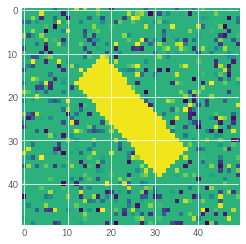

In [25]:
test_im = X_train[54]
plt.imshow(test_im.reshape(50, 50), cmap='viridis', interpolation='none')

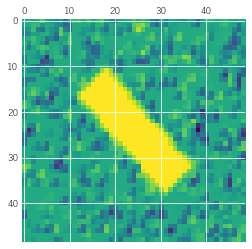

In [26]:
#最初のレイヤーの2番めのチャネルのActivationを見てみましょう
from keras import models
layer_outputs = [layer.output for layer in model.layers[:8] ]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_im.reshape(1,50,50,1))

first_layer_activation = activations[0]
#配列を行列として表示する
plt.matshow(first_layer_activation[0, : , : , 4], cmap='viridis')

In [27]:
#モデルをセーブ→ロードしてpredictできるのか
model.save('receipt_angle_learning.h5')